# Low level API


**Objective: A full fitting of MSH 15-52**


Here, we have to interact with the data archive (with the `~gammapy.data.DataStore`) to retrieve a list of selected observations (`~gammapy.data.Observations`). Then, we define the geometry of the `~gammapy.datasets.MapDataset` object we want to produce and the maker object that reduce an observation
to a dataset. 

We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry and stack them together (i.e. sum them all).

In practice, we have to:
- Create a `~gammapy.data.DataStore` poiting to the relevant data 
- Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Define a geometry of the Map we want to produce, with a sky projection and an energy range.
    - Create a `~gammapy.maps.MapAxis` for the energy
    - Create a `~gammapy.maps.WcsGeom` for the geometry
- Create the necessary makers : 
    - the map dataset maker : `~gammapy.makers.MapDatasetMaker`
    - the background normalization maker, here a `~gammapy.makers.FoVBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.MapDataset`
    - Stack it on the target one.
- Define the `~gammapy.modeling.models.SkyModel` to apply to the dataset.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Setup
First, we setup the analysis by performing required imports.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    Models
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse. Here the H.E.S.S. DL3 DR1. 

In [4]:
data_store = DataStore.from_dir("/Users/terrier/Code/gammapy-dev/gammapy-data/hess-dl3-dr1")

In [5]:
from astropy.coordinates import SkyCoord
pos = SkyCoord.from_name("MSH 15-52")
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (228.32083333, -59.08166667)>

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [6]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pos.ra,
    lat=pos.dec,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [7]:
selected_obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20301,228.6125,-58.771667,320.56754,-0.8857012,36.839905,53.160095,171.07347,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1534.0626,0.9115048,103764878.0,103766561.0,2004-04-15,23:35:42.184,2004-04-16,00:03:45.184,4,"1,2,3,4",0,1.1503073,11624,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20302,228.6125,-59.771667,320.04724,-1.7397733,36.11632,53.88368,177.10521,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.3478,0.9128108,103766698.0,103768380.0,2004-04-16,00:06:02.184,2004-04-16,00:34:04.184,4,"1,2,3,4",0,1.1493496,11794,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20303,228.6125,-58.771667,320.56754,-0.8857012,36.186012,53.813988,183.91011,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.1606,0.9126996,103768520.0,103770202.0,2004-04-16,00:36:24.184,2004-04-16,01:04:26.184,4,"1,2,3,4",0,1.1557641,11803,MSH 15-52,msh1552,0.38821736,0.3801894,100.0


We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [8]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

No HDU found matching: OBS_ID = 20136, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20137, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20151, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20282, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20283, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20301, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20302, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20303, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20322, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20323, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20324, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20325, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20343, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found

In [9]:
print(observations)

Observations
Number of observations: 20
Observation

	obs id            : 20136 
 	tstart            : 53090.12
	tstop             : 53090.14
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 9.6%
Observation

	obs id            : 20137 
 	tstart            : 53090.14
	tstop             : 53090.16
	duration          : 902.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 20151 
 	tstart            : 53091.10
	tstop             : 53091.12
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 9.1%
Observation

	obs id            : 20282 
 	tstart            : 53109.98
	tstop             : 53110.00
	duration          : 1687.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 8.5%
Observation

	obs id            : 20283 
 	tstart            : 53110.00
	tstop             : 53110.02
	duration          : 1683.00 s
	pointing (icrs)   :

In [10]:
obs = observations[0]

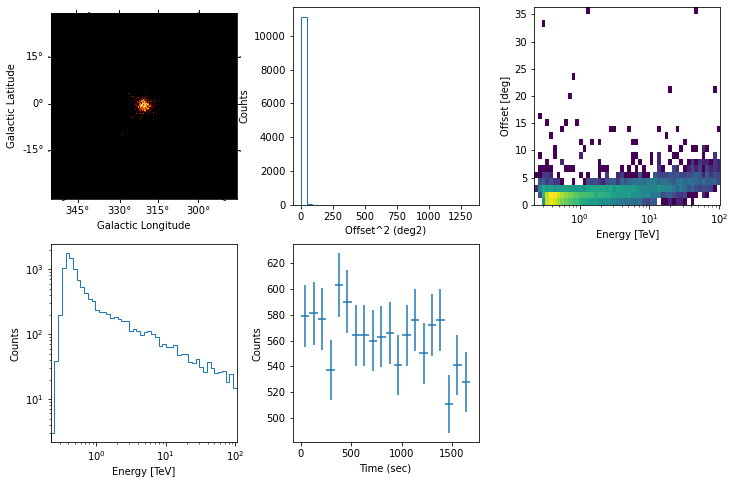

In [11]:
obs.events.peek()

## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis, We choose a WCS based geometry with a binsize of 0.02 deg and also define an energy axis: 

In [14]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

geom = WcsGeom.create(
    skydir=(pos.ra.value, pos.dec.value),
    binsz=0.02,
    width=(5, 5),
    frame="icrs",
    proj="TAN",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", name="energy_true"
)

In [13]:
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (250, 250, 15)
	ndim       : 3
	frame      : icrs
	projection : TAN
	center     : 228.3 deg, -59.1 deg
	width      : 5.0 deg x 5.0 deg
	wcs ref    : 228.3 deg, -59.1 deg



Now we can define the target dataset with this geometry.

In [15]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="msh-stacked"
)

In [17]:
print(stacked)

MapDataset
----------

  Name                            : msh-stacked 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




## Data reduction

### Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.

In [22]:
maker = MapDatasetMaker(selection=['counts','background', 'psf', 'edisp', 'exposure'])

In [23]:
offset_max = 2.3 * u.deg

maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=offset_max
)

In [24]:
circle = CircleSkyRegion(
    center=SkyCoord(pos.ra, pos.dec), radius=0.4 * u.deg
)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

In [25]:
exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

The `FoVBackgroundMaker` performs the background normalisation outside the exclusion region

### Perform the data reduction loop

In [26]:
%%time

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 20136: 0.95
Background norm obs 20137: 0.94
Background norm obs 20151: 0.91
Background norm obs 20282: 0.88
Background norm obs 20283: 0.64
Background norm obs 20301: 0.93
Background norm obs 20302: 0.95
Background norm obs 20303: 0.92
Background norm obs 20322: 1.00
Background norm obs 20323: 0.97
Background norm obs 20324: 0.98
Background norm obs 20325: 0.95
Background norm obs 20343: 0.91
Background norm obs 20344: 0.99
Background norm obs 20345: 0.95
Background norm obs 20346: 1.00
Background norm obs 20365: 0.97
Background norm obs 20366: 0.90
Background norm obs 20367: 0.92
Background norm obs 20368: 0.82
CPU times: user 58.3 s, sys: 14.9 s, total: 1min 13s
Wall time: 1min 14s


In [27]:
print(stacked)

MapDataset
----------

  Name                            : msh-stacked 

  Total counts                    : 62754 
  Total background counts         : 61879.19
  Total excess counts             : 874.81

  Predicted counts                : 61879.18
  Predicted background counts     : 61879.19
  Predicted excess counts         : nan

  Exposure min                    : 1.73e-02 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 654810 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Inspect the reduced dataset

In [34]:
print(stacked.psf)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (25, 25, 66, 20)
	ndim  : 4
	unit  : 1 / sr
	dtype : float32



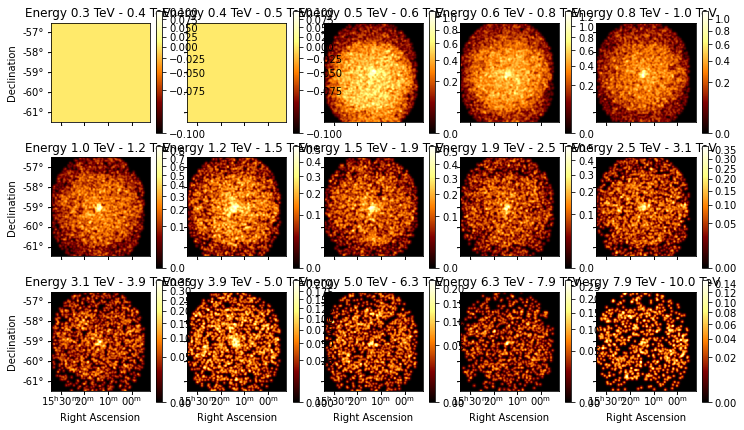

In [37]:
stacked.counts.smooth(0.04 * u.deg).plot_grid(
    stretch="sqrt", add_cbar=True, ncols=5
);

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


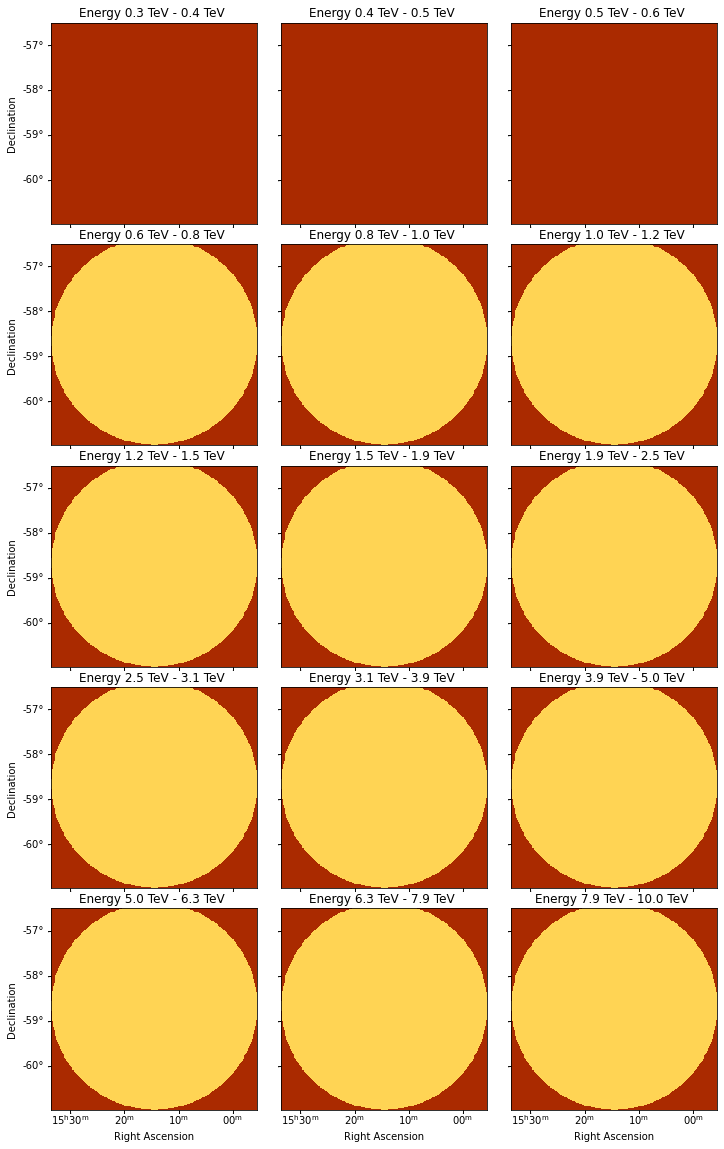

In [38]:
dataset.mask_safe.plot_grid(vmin=-1, vmax=2);

Save the dataset to disc using `~gammapy.datasets.MapDataset.write()` method:

In [39]:
filename = "msh-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

In [40]:
stacked.to_hdulist()

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x13f3d9110>, <astropy.io.fits.hdu.image.ImageHDU object at 0x13f48a0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x139421fd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x139404190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1394042d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1393faf90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x13c8fafd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x13c94c750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x13a888450>, <astropy.io.fits.hdu.image.ImageHDU object at 0x13a686950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x139a160d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x138e4c610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x13a878b50>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1392b4e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1392b4d50>, <astropy.io.fits.hdu.image.ImageHDU object at 0x13c820f90>, <astropy.io.fits

In [ ]:
region = CircleSkyRegion(
    center=SkyCoord(228.32083333, -59.08166667, unit="deg"), radius=0.4 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region})

In [ ]:
stacked.exposure

At this stage, we have created a DL4 `MapDataset`. The rest of the notebook is agnostic to how this dataset was created (simulated/H.E.S.S./Fermi-LAT, etc)...

If you are interested only in the spectrum, not the morphology, you can do a 1D spectral extraction using the `SpectrumDatasetMaker`. See https://docs.gammapy.org/0.19/tutorials/index.html#d-spectral for details.

## Compute an excess and a significance map

In [41]:
stacked = MapDataset.read("msh-stacked-dataset.fits.gz", name="msh-dataset")

In [57]:
estimator = ExcessMapEstimator(0.1 * u.deg, selection_optional=[], energy_edges=[0.6, 2, 10]*u.TeV)
flux_maps = estimator.run(stacked)

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


array([<WCSAxesSubplot:title={'center':'Energy 0.6 TeV - 1.9 TeV '}, xlabel='Right Ascension', ylabel='Declination'>,
       <WCSAxesSubplot:title={'center':'Energy 1.9 TeV - 10.0 TeV '}, xlabel='Right Ascension'>],
      dtype=object)

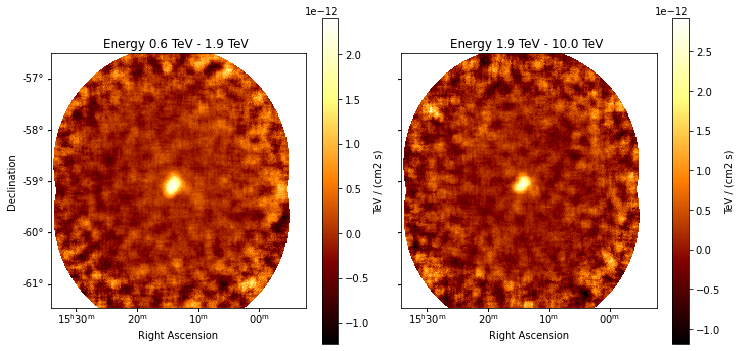

In [59]:
flux_maps.eflux.plot_grid(add_cbar=True)

<WCSAxesSubplot:title={'center':'Excess map'}, xlabel='Right Ascension', ylabel='Declination'>

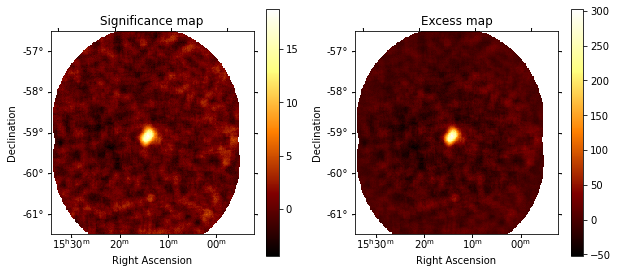

In [49]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=flux_maps.sqrt_ts.geom.wcs)
ax2 = plt.subplot(222, projection=flux_maps.sqrt_ts.geom.wcs)

ax1.set_title("Significance map")
flux_maps.sqrt_ts.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
flux_maps.npred_excess.plot(ax=ax2, add_cbar=True)

In [ ]:
## You can zoom into your region
significance_map.cutout(position=pos, width=0.8*u.deg).plot(add_cbar=True)

## Is the source extended? Look at the radial profiles

For details, see: https://docs.gammapy.org/0.19/tutorials/analysis/3D/flux_profiles.html

In [ ]:
from gammapy.utils.regions import (
    make_concentric_annulus_sky_regions,
)
from gammapy.maps import RegionGeom
from gammapy.estimators import FluxProfileEstimator, FluxPoints

In [ ]:
pos

In [ ]:
regions = make_concentric_annulus_sky_regions(
    center=SkyCoord(228.5, -59.15, unit="deg"),
    radius_max="0.6 deg",
    nbin=6,
)
regions

In [ ]:
geom = RegionGeom.create(region=regions)
geom

In [ ]:
img = stacked.counts.sum_over_axes().cutout(position=SkyCoord(228.5, -59.15, unit="deg"), 
                                           width=1.2*u.deg)
ax = img.smooth(0.02*u.deg).plot(add_cbar=True)
geom.plot_region(ax=ax, color="w");

In [ ]:
flux_profile_estimator = FluxProfileEstimator(
    regions=regions,
    energy_edges=[0.5,2,10] * u.TeV,
    selection_optional=["ul", "scan"],
    norm_values=np.linspace(-1, 5, 11),
)

In [ ]:
%%time
profile = flux_profile_estimator.run(datasets=dataset)

In [ ]:
profile

In [ ]:
ax = profile.plot(axis_name="projected-distance", sed_type="flux")

In [ ]:
ax = profile.npred_excess.plot(axis_name="projected-distance")
ax.set_xbound(-0.01,0.6)

## Define the model
We first define the model, a `SkyModel`, as the combination of a point source `SpatialModel` with a powerlaw `SpectralModel`:

In [60]:

spatial_model = GaussianSpatialModel(
    lon_0=pos.ra, lat_0=pos.dec, sigma=0.3*u.deg, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="msh"
)

bkg_model = FoVBackgroundModel(dataset_name="msh-stacked")

In [64]:
other_model = SkyModel.create(spectral_model="pl", spatial_model="gauss")

In [67]:
other_model.parameters["sigma"]

Parameter(name='sigma', value=1.0, factor=1.0, scale=1.0, unit=Unit("deg"), min=0.0, max=nan, frozen=False, id=0x13b306b90)

Now we assign this model to our reduced dataset:

In [68]:
stacked.models = [sky_model, bkg_model]

In [69]:
print(stacked)

MapDataset
----------

  Name                            : msh-dataset 

  Total counts                    : 62754 
  Total background counts         : 61879.19
  Total excess counts             : 874.81

  Predicted counts                : 68268.95
  Predicted background counts     : 61879.19
  Predicted excess counts         : 6389.76

  Exposure min                    : 1.73e-02 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 654810 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 361287.83

  Number of models                : 1 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : msh
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
      inde

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its constructor takes a list of dataset as argument.

In [78]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

Value 0.0 is outside bounds [0.0, 1.0] for parameter 'e'


W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000376141 is smaller than machine limit 0.0213781 while 0.0002 was requested
CPU times: user 21.7 s, sys: 2.79 s, total: 24.5 s
Wall time: 24.9 s


The `FitResult` contains information about the optimization and parameter error calculation.

In [79]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 181
	total stat : 358665.01

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 181
	total stat : 358665.01




The fitted parameters are visible from the `~astropy.modeling.models.Models` object.

In [80]:
stacked.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str3,str8,str9,float64,str14,float64,float64,float64,bool,str1
msh,spectral,index,2.1685e+00,,6.527e-02,nan,nan,False,
msh,spectral,amplitude,6.6477e-12,cm-2 s-1 TeV-1,3.957e-13,nan,nan,False,
msh,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
msh,spatial,lon_0,2.2854e+02,deg,1.323e-02,nan,nan,False,
msh,spatial,lat_0,-5.9174e+01,deg,7.439e-03,-9.000e+01,9.000e+01,False,
msh,spatial,sigma,9.8922e-02,deg,8.080e-03,0.000e+00,nan,False,
msh,spatial,e,5.2509e-01,,1.825e-01,0.000e+00,1.000e+00,False,
msh,spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,


In [76]:
sky_model.parameters["e"].frozen=False

### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few options on the dataset object to handle this. First we can use `.plot_residuals_spatial()` to plot a residual image, summed over all energies:

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

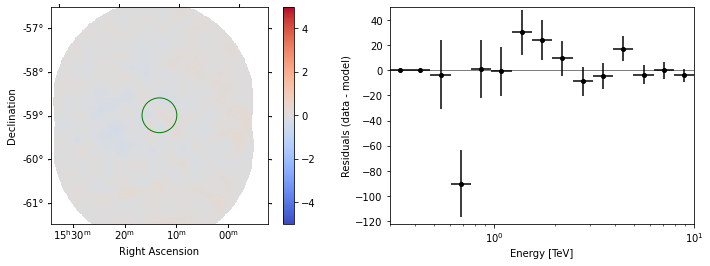

In [81]:
region = CircleSkyRegion(
    center=SkyCoord(228.32083333, -59.08166667, unit="deg"), radius=0.4 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region})

In [82]:
flux_maps = estimator.run(stacked)

array([<WCSAxesSubplot:title={'center':'Energy 0.6 TeV - 1.9 TeV '}, xlabel='Right Ascension', ylabel='Declination'>,
       <WCSAxesSubplot:title={'center':'Energy 1.9 TeV - 10.0 TeV '}, xlabel='Right Ascension'>],
      dtype=object)

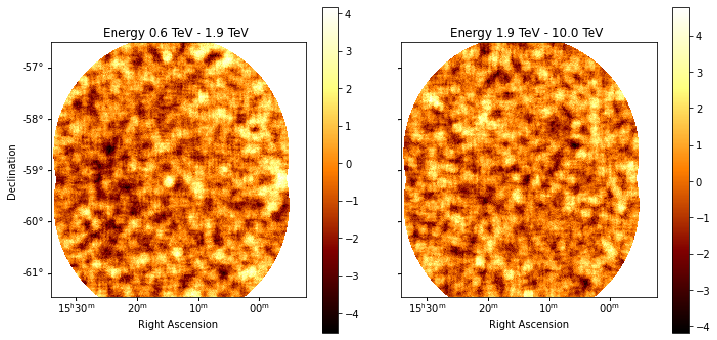

In [83]:
flux_maps.sqrt_ts.plot_grid(add_cbar=True)

## Plot the fitted spectrum

### Making a butterfly plot 

The `SpectralModel` component can be used to produce a, so-called, butterfly plot showing the envelope of the model taking into account parameter uncertainties:

In [84]:
spec = sky_model.spectral_model

Now we can actually do the plot using the `plot_error` method:

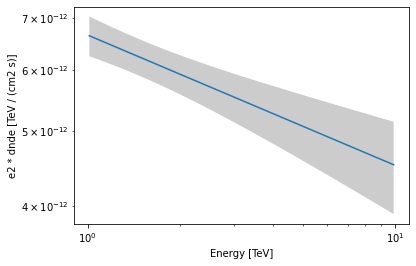

In [85]:
energy_bounds = [1, 10] * u.TeV
spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)

<AxesSubplot:>

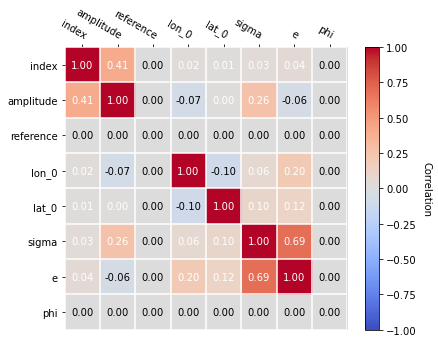

In [88]:
stacked.models.covariance.plot_correlation()

### Computing flux points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [89]:
energy_edges = [0.5, 1, 2, 4, 10] * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="msh")

In [90]:
%%time
flux_points = fpe.run(datasets=[stacked])

CPU times: user 7.06 s, sys: 2.12 s, total: 9.18 s
Wall time: 9.36 s


<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde (TeV / (cm2 s))'>

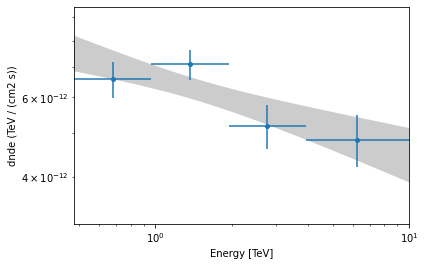

In [91]:
ax = spec.plot_error(energy_bounds=[0.3, 20] * u.TeV, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

In [92]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool
0.6799228374302683,0.47881941762421254,0.9654893846056297,1.534548078155668e-11,7.523768591186933e-12,4.978096954869241e-12,0.9254729137518347,0.08377920656910709,176.55663961701794,13.287461744705718,37622.64486327352,370.66895,163391.00051471728,False,36028.0,True
1.3709934428872002,0.9654893846056297,1.9468085826831354,3.3536377299575868e-12,3.315483156236652e-12,4.423341767944765e-12,1.1244961117768426,0.0871541261427558,305.26275109141716,17.47177011900675,14021.544010449932,338.11713,93778.1582717262,False,14695.0,True
2.7644651965855895,1.9468085826831354,3.9255363321853953,7.329119356959089e-13,1.461026934316545e-12,3.930408060234056e-12,0.9250653721723812,0.10170713646919782,158.34308192605386,12.58344475595033,6808.714743881568,162.26213,57339.83686401204,False,7296.0,True
6.26541006813233,3.9255363321853953,10.000000000000002,1.243111401259421e-13,7.650699905176983e-13,4.5678075207437255e-12,0.990956969285042,0.12903833155636096,129.24525266181445,11.368608211290178,4398.980716365303,101.65326,44152.85593283343,False,4735.0,True


In [94]:
print(stacked.counts.geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (250, 250, 15)
	ndim       : 3
	frame      : icrs
	projection : TAN
	center     : 228.3 deg, -59.1 deg
	width      : 5.0 deg x 5.0 deg
	wcs ref    : 228.3 deg, -59.1 deg



In [100]:
new_axis = MapAxis.from_energy_edges([0.6,0.7,2., 5., 50], unit='TeV')

In [97]:
new_dataset = stacked.resample_energy_axis(new_axis)

In [98]:
print(new_dataset.counts.geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (250, 250, 6)
	ndim       : 3
	frame      : icrs
	projection : TAN
	center     : 228.3 deg, -59.1 deg
	width      : 5.0 deg x 5.0 deg
	wcs ref    : 228.3 deg, -59.1 deg

